# Лабораторная работа №5

**Многослойный перцептрон в pytorch**

---

**Впишите в эту ячейку ваши ФИО, группу и вариант**.

ФИО: Сильченко Алексей Евгеньевич   

Группа: 201-361

---

## Работа с тензорами

**Совет по работе**

Создавайте отдельные ячейки для ваших экспериментов. Пробуйте создавать небольшие тензоры и экспериментировать с ними, чтобы понять, как работает та или иная функция и какие размерности данных вам требуются.

Когда дойдете до цикла обучения сначала пробуйте работать с одной эпохой и ограниченным набором пакетов данных, чтобы меньше времени ожидать до обнаружения ошибки.

Создайте тензор a из `list(range(9))`.

In [8]:
import torch

a = torch.tensor(list(range(9)))
print(a)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


**Каковы его размеры (`size`), сдвиг (`storage_offset`) и шаг (`stride`)?**

Ваш ответ:
- `size` = 9 
- `storage_offset` = 0 - указывает на индекс с которого начинаются данные в тензоре, в данном случае равен 0, т.к. данные начинаются с 1-го элемента
- `stride` = 1

Создайте новый тензор b размерностью 3 на 3, используя метод `view` на тензоре a.

In [9]:
b = a.view(3, 3)
print(b)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


**Что делает view?**

Ваш ответ: Метод `view` в PyTorch используется для изменения формы тензора без изменения его данных. Он возвращает новый тензор, который имеет указанную форму, но использует те же данные, что и исходный тензор, так что изменения в одном тензоре отражаются в другом. 

Создайте тензор c, который содержит только последнюю колонку тензора b, используя срезы.

In [10]:
c = b[:, -1]
print(c)

tensor([2, 5, 8])


Измените последний элемент в тензоре c.

In [11]:
c[-1] = 99
print("Тензор c:")
print(c)
print("Тензор b:")
print(b)

Тензор c:
tensor([ 2,  5, 99])
Тензор b:
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7, 99]])


**Изменился ли при этом тензор a?**

Ваш ответ: Да, тензор `a` также изменился. Это связано с тем, что в PyTorch операция `view` создаёт новый тензор, который является представлением исходного тензора, не копируя данные. 

## Чтение данных и dataset

Из встроенных датасетов torchvision загрузите тестовую и обучающую выборки из MNIST, указав преобразование для изображений используя ToTensor().

In [12]:
from torchvision import datasets #библиотека с утилитами для компьютерного зрения
from torchvision.transforms import ToTensor #библиотека для преобразования изображений в тензоры

#обучающий набор данных
train_set = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Создание тестового набора данных
test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Датасеты позволяют получить общее количество объектов с помощью функции `len`, также - объект с классом по индексу. В атрибуте `classes` хранятся ярлыки классов.

In [13]:
# Длина обучающего и тестового наборов
train_samples_len = len(train_set)
test_samples_len = len(test_set)

# Получаем форму первого изображения в обучающем наборе
image_shape = train_set[0][0].shape

# Количество классов и их ярлыки
classes_len = len(train_set.classes)
classes_labels = train_set.classes

print(train_samples_len, test_samples_len, image_shape, classes_len, classes_labels)

60000 10000 torch.Size([1, 28, 28]) 10 ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## Создание dataloader

Данные при обучении модели редко передаются по одному образцу или все разом, обычно образцы объединяются в пакеты (batches) и уже они передаются на вход модели.

Размер пакета (batch size) часто выбирается как $2^n$ (16, 32, 64, 128) и часто это зависит от доступной памяти.

Загрузчики данных будут использоваться при обучении и тестировании модели и когда все пакеты были перебраны в датасете, это считается одной эпохой обучения. Чтобы между эпохами модель на обучалась на одинаковых пакетах их перемешивают (shuffle).

In [14]:
from torch.utils.data import DataLoader

In [15]:
train_loader = DataLoader(train_set, 32, shuffle=True)

# Создание загрузчика данных для тестового набора
# Здесь shuffle=False, так как перемешивание не требуется
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

**Что означает число 32 в примере для train_loader?**

Ваш ответ: Это количество образцов данных, которые будут сгруппированы в один пакет и переданы на обработку модели за один раз во время обучения.

**Какая размерность будет у одного пакета данных?**

Ваш ответ: Размерность одного пакета данных будет [32, 1, 28, 28] для изображений и [32] для меток.

## Создание модели

Ваша задача при инициализации MLP, создать несколько линейных слоев и функцию активации (например ReLU), которые будут использоваться при прямом проходе в модели. Перед входным слоем не забудьте использовать для изображений `.flatten()`. Чтобы вы могли использовать пакеты данных, вам надо подумать какую часть тензора сделать "плоской".

- Линейный слой `nn.Linear`
- Функция активации `nn.ReLU`

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class MLP(nn.Module):

  def __init__(self):
    super(MLP, self).__init__()
    # Первый линейный слой: 784 входа (28x28 пикселей), 128 выходов
    self.fc1 = nn.Linear(784, 128)
    # Второй линейный слой: 128 входов, 64 выхода
    self.fc2 = nn.Linear(128, 64)
    # Третий (выходной) линейный слой: 64 входа, 10 выходов (количество классов в MNIST)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    # Уплощаем входной тензор x, кроме первого измерения (пакета)
    x = x.view(-1, 28*28)  # Или x = x.flatten(start_dim=1)
    # Прямой проход через первый слой, затем активация ReLU
    x = F.relu(self.fc1(x))
    # Прямой проход через второй слой, затем активация ReLU
    x = F.relu(self.fc2(x))
    # Прямой проход через третий слой (без активации после последнего слоя)
    x = self.fc3(x)
    return x

In [18]:
# Создание экземпляра класса MLP
model = MLP()


In [19]:
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [20]:
for param in model.parameters():
  print(param.shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


**Сколько параметров в вашей модели?**

Ваш ответ:
- Входной слой: 784 входа на 128 выходов + 128 смещений
params_fc1 = 784 * 128 + 128
- Второй слой: 128 входов на 64 выхода + 64 смещения
params_fc2 = 128 * 64 + 64
- Выходной слой: 64 входа на 10 выходов + 10 смещений
params_fc3 = 64 * 10 + 10
- Общее количество параметров
total_params = params_fc1 + params_fc2 + params_fc3
- total_params = 109386


## Функция потерь и оптимизатор

В задаче классификации чаще всего используется функция потерь на основе перекрестной энтропии.

В качестве оптимизатора для параметров модели можно выбрать стохастический градиентный спуск или Adam.

In [21]:
loss_fn = nn.CrossEntropyLoss()

In [22]:
from torch.optim import SGD

LR = 0.01

optimizer = SGD(model.parameters(), lr=LR)

## Цикл обучения

In [23]:
import torch.nn.functional as F

n_epochs = 10

best_acc = 0

for epoch in range(n_epochs):
  train_loss = 0
  train_correct = 0
  test_loss = 0
  test_correct = 0
  print(f"Эпоха №{epoch+1}")
  model.train() # переключение модели в режим обучения
  for imgs, labels in train_loader:
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(imgs)  # Получаем вывод модели
    loss = loss_fn(outputs, labels)  # Вычисляем потери
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры

    train_loss += loss.item()
    train_correct += (outputs.argmax(1) == labels).sum().item()

  avg_train_loss = train_loss / len(train_loader)
  train_acc = train_correct / len(train_loader.dataset)
  print(f"Потери на обучающей выборке {avg_train_loss:.5f}")
  print(f"Точность на обучающей выборке: {train_acc*100:.2f}%")

  model.eval() # переключение модели в режим оценивания
  for imgs, labels in test_loader:
    with torch.no_grad(): # работа в контексте отключенного вычисления градиентов
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      test_loss += loss.item()
      test_correct += (outputs.argmax(1) == labels).sum().item()

  avg_test_loss = test_loss / len(test_loader)
  test_acc = test_correct / len(test_loader.dataset)
  print(f"Потери на обучающей выборке {avg_test_loss:.5f}")
  print(f"Точность на обучающей выборке: {test_acc*100:.2f}%")

  if test_acc > best_acc:
    best_acc = test_acc
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            }, "best_model_params.pth")

Эпоха №1


Потери на обучающей выборке 1.15616
Точность на обучающей выборке: 71.16%
Потери на обучающей выборке 0.42873
Точность на обучающей выборке: 87.80%
Эпоха №2
Потери на обучающей выборке 0.37495
Точность на обучающей выборке: 89.38%
Потери на обучающей выборке 0.31813
Точность на обучающей выборке: 90.93%
Эпоха №3
Потери на обучающей выборке 0.30720
Точность на обучающей выборке: 91.27%
Потери на обучающей выборке 0.27656
Точность на обучающей выборке: 92.01%
Эпоха №4
Потери на обучающей выборке 0.26826
Точность на обучающей выборке: 92.40%
Потери на обучающей выборке 0.24291
Точность на обучающей выборке: 93.18%
Эпоха №5
Потери на обучающей выборке 0.23734
Точность на обучающей выборке: 93.22%
Потери на обучающей выборке 0.22032
Точность на обучающей выборке: 93.75%
Эпоха №6
Потери на обучающей выборке 0.21056
Точность на обучающей выборке: 94.09%
Потери на обучающей выборке 0.19576
Точность на обучающей выборке: 94.30%
Эпоха №7
Потери на обучающей выборке 0.18836
Точность на обучающей 

**Почему для оценки модели стоит отключать вычисление градиентов `with torch.no_grad()`?**

Ваш ответ: экономия ресурсов, предотвращение изменения в модели, корректная оценка модели

## Загрузка модели и инференс

Ранее были оптимизированы параметры модели и словарь с параметрами для лучшей точности на проверочной выборке был сохранен в виде файла.

Модель обучается для ее использования с реальными данными, что и будет сделано в этой части задания.

Для этого вам потребуется нарисовать цифру в любом графическом редакторе (Paint, Gimp, Photoshop).

Требования к изображению происходят из тех данных, на которых обучалась модель. Поэтому изображение должно быть черно-белое, ширина и высота 28 px, черный фон, белая цифра. Формат может быть как png, так и jpg.

Для загрузки изображения в Google Colab в боковой панели откройте Files (1), и выберите вариант Upload to session storage (2).

Затем файл необходимо считать и подготовить перед тем, как передать в модель.

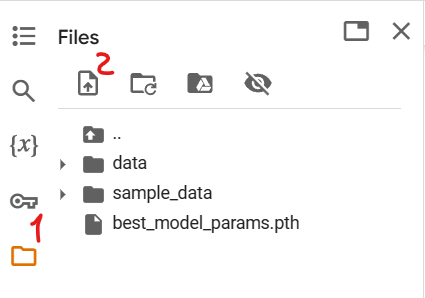

In [24]:
from PIL import Image
img = Image.open('photo/3new.jpg')
print(f"Ширина и высота {img.size}, количество каналов {len(img.mode)}")
img

Ширина и высота (28, 28), количество каналов 1


**Соответствует ли изображение требованиям?**

Ваш ответ: нет


Если количество каналов у вас больше одного, то код далее поможет это исправить.

In [25]:
import torchvision.transforms as transforms
# Раскомментируйте, если у вас цветное изображение
transform_grayscale = transforms.Grayscale()
img = transform_grayscale(img)

# Используем те же преобразования как и при создании датасетов в начале задания
transform_to_tensor = transforms.ToTensor()
x = transform_to_tensor(img)

# Вывод размерностей тензора x
print(x.shape)

torch.Size([1, 28, 28])


Но работа нашей модели строилась с учетом использования пакетов данных (batches), которые создавали экземпляры класса DataLoader, поэтому для использования одного изображения нам надо имитировать пакет из одного изображения. С этим поможет метод тензора `unsqueeze`, а чтобы не создавать отдельную переменную можно воспользоваться методом `unsqueeze_`.

In [26]:
# Имитация пакета из одного изображения
x.unsqueeze_(0)  # Добавляет дополнительное измерение

# Вывод размерности модифицированного тензора x
print(f"Размерность тензора x после unsqueeze: {x.size()}")

Размерность тензора x после unsqueeze: torch.Size([1, 1, 28, 28])


Изображение подготовлено, теперь необходимо воссоздать модель и загрузить в нее параметры, которые дали наилучший результат при обучении.

In [27]:
best_model = MLP()
best_model_params = torch.load('best_model_params.pth') # Укажите путь до сохраненного файла
state_dict = best_model_params['model_state_dict'] # Из best_model_params извлеките по соответствующему ключу параметры модели
# Загрузка параметров в модель
best_model.load_state_dict(state_dict)

# Переключение модели в режим проверки
best_model.eval()

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Осталось воспользоваться моделью. Передайте на вход модели подготовленный тензор. Из вывода модели получите индекс наибольшего значения (`argmax`) и по индексу получите результат из массива ярлыков классов (`test_set.classes`).

In [28]:
with torch.no_grad():  # Отключаем вычисление градиентов
    output = best_model(x)  # Передаем тензор через модель

# Получаем индекс наибольшего значения в выводе модели
predicted_index = torch.argmax(output, dim=1).item()

# Используем индекс для получения названия класса
predicted_class = test_set.classes[predicted_index]

print(f"Предсказанный класс: {predicted_class}")

Предсказанный класс: 3 - three


**Правильно ли предсказала модель цифру?**

Ваш ответ: да

**Лучшая точность на тестовой выборке для вашей модели.**

Ваш ответ: 95.63%

**Что такое пакет данных (batch)?**

Ваш ответ: 
Пакет данных (batch) — это набор образцов данных, используемый при обучении нейронной сети, который обрабатывается за один проход алгоритма обучения. Вместо обучения модели на одном образце за раз (что может быть неэффективно и медленно) или на всем наборе данных сразу (что может требовать слишком много памяти), данные разбиваются на меньшие пакеты.

**В чем заключается смысл стохастического градиентного спуска?**

Ваш ответ: Стохастический градиентный спуск (Stochastic Gradient Descent, SGD) — это итеративный метод оптимизации, используемый для минимизации функции потерь при обучении машинных моделей, в частности, нейронных сетей. В отличие от классического градиентного спуска, который вычисляет градиент функции потерь на всем тренировочном наборе данных (что может быть вычислительно затратно для больших данных), SGD обновляет веса модели, используя градиент, вычисленный на основе одного случайно выбранного образца или небольшого пакета образцов.